#  Exploratory Data Analysis of Aphex Twin's Music Using Spotify Metrics


This notebook analyzes Aphex Twin’s music using Spotify’s audio features. It explores various metrics, such as energy, Valence and Danceability, to understand their relationship with track characteristics and popularity.

The analysis involves calculating custom "Bangerness" and "Ambientness" scores to assess track intensity and atmosphere. Additionally, the analysis examines how features such as energy and acousticness correlate with track popularity.



The initial dataset was compiled using Spotify's API, covering all available Aphex Twin tracks and their associated features. [The code used to generate this dataset can be found here](https://github.com/iftah-og/afx_eda/blob/main/spot_to_df.ipynb).

In [3]:
# Import necessary stuff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [4]:
# Load the dataset from the specified URL 
url = 'https://raw.githubusercontent.com/iftah-og/afx_eda/main/afx.csv'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,Track Name,Album Name,Track ID,Popularity,Tempo (BPM),Duration (s),Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Release Date
0,0,Digeridoo - 2022 Remaster,Digeridoo (Expanded Edition),2Fh8MjqWLFCoiOOHQRfqgq,40,146.092,432.938,0.519,0.977,10,-8.057,0,0.0544,0.774,0.855,0.114,0.568,2024-05-31
1,1,Flap Head - 2022 Remaster,Digeridoo (Expanded Edition),24nMZbhkJNqJ70P1J81ZNx,35,136.244,420.766,0.566,0.995,1,-7.022,1,0.0503,0.151,0.886,0.399,0.592,2024-05-31
2,2,Phloam - 2022 Remaster,Digeridoo (Expanded Edition),2jft0p7lZNXkKksCFHbsKr,32,135.88,333.535,0.525,0.977,10,-8.163,0,0.131,0.000882,0.44,0.145,0.238,2024-05-31
3,3,Isoprophlex - 2022 Remaster,Digeridoo (Expanded Edition),1U3W1jTqreI3YL84sA1eCx,30,135.609,383.964,0.646,0.914,1,-9.003,0,0.073,0.234,0.768,0.039,0.339,2024-05-31
4,4,Digeridoo - Cr7E Version,Digeridoo (Expanded Edition),2Ujum3PkQL0x3QMnGoJGPf,34,142.844,445.314,0.533,0.972,7,-8.425,1,0.0521,0.765,0.906,0.123,0.415,2024-05-31


In [5]:
df.columns

Index(['Unnamed: 0', 'Track Name', 'Album Name', 'Track ID', 'Popularity',
       'Tempo (BPM)', 'Duration (s)', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Release Date'],
      dtype='object')

### Routine check for types

In [6]:
df.dtypes

Unnamed: 0            int64
Track Name           object
Album Name           object
Track ID             object
Popularity            int64
Tempo (BPM)          object
Duration (s)        float64
Danceability         object
Energy               object
Key                  object
Loudness             object
Mode                 object
Speechiness          object
Acousticness         object
Instrumentalness     object
Liveness             object
Valence              object
Release Date         object
dtype: object

### Numeric conversion 

In [7]:
# Ensure 'Release Date' is in datetime format
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')

# Convert columns to numeric
numeric_cols = ['Tempo (BPM)', 'Danceability', 'Energy', 'Loudness', 'Acousticness', 
                'Instrumentalness', 'Valence', 'Speechiness','Key','Mode', 'Popularity', 'Duration (s)', 'Liveness']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Ensure 'Release Date' is in datetime format and handle NaT values
df['Release Date Numeric'] = df['Release Date'].apply(lambda x: x.timestamp() if pd.notnull(x) else pd.NA)

df.dtypes


Unnamed: 0                       int64
Track Name                      object
Album Name                      object
Track ID                        object
Popularity                       int64
Tempo (BPM)                    float64
Duration (s)                   float64
Danceability                   float64
Energy                         float64
Key                            float64
Loudness                       float64
Mode                           float64
Speechiness                    float64
Acousticness                   float64
Instrumentalness               float64
Liveness                       float64
Valence                        float64
Release Date            datetime64[ns]
Release Date Numeric           float64
dtype: object

This section replaces all instances of 'No data' with NaN in the DataFrame and subsequently removes any rows that contain NaN values. 

In [8]:
# Replace 'No Data' with NaN
df.replace('No data', pd.NA, inplace=True)

# Drop the column 'Unnamed: 0' from the DataFrame
df.drop(columns=['Unnamed: 0'], inplace=True)

# Drop rows with NaN values
df.dropna(inplace=True)

## Danceability: Really? 
The first thing I wanted to explore was how "Danceability" translates into real-life listening. I sorted the data frame to highlight the most danceable tracks according to Spotify's metrics, and the results were surprising. For instance, I've always appreciated the eerie vibe of ***#8***, but is it really the most danceable track? While danceability is subjective, most people wouldn't rank it anywhere near the top. My guess is that Spotify calculates "Danceability" based on the repetition of patterns throughout a track—and if you know the track in question, you're familiar with the relentless analog drums that never stop. he next track on the list (***Cow Cud Is A Twin***) further supports this idea. Just listen to it—again, there's a repetitive drum loop running throughout the entire track.

In [23]:
df_dance_pos = df.sort_values(['Danceability'], ascending=False).head()
df_dance_pos [['Album Name', 'Track Name', 'Danceability', 'Tempo (BPM)']]

,Album Name,Track Name,Danceability,Tempo (BPM)
89,Selected Ambient Works Volume II,#8,0.942,112.947
80,...I Care Because You Do,Cow Cud Is A Twin,0.851,79.002
14,Syro,180db_ [130],0.828,130.064
24,Drukqs,Kladfvgbung Mischk,0.816,129.984
12,Syro,produk 29 [101],0.815,101.005


however, Danceability seems to do a good job on the other side of the spectrum, tracks with extreme low Danceability are rather on the ambient side.

In [24]:
df_dance_neg = df.sort_values(['Danceability'], ascending=True).head()
df_dance_neg [['Album Name', 'Track Name', 'Danceability', 'Tempo (BPM)']]

,Album Name,Track Name,Danceability,Tempo (BPM)
103,Selected Ambient Works Volume II,#22,0.064,76.311
91,Selected Ambient Works Volume II,#10,0.105,66.738
101,Selected Ambient Works Volume II,#20,0.108,69.511
81,...I Care Because You Do,Next Heap With,0.109,76.229
95,Selected Ambient Works Volume II,#14,0.124,153.964


## How about the Energy?
Next, I wanted to explore the "Energy" metric. Here, too, the results were a bit mixed. For instance, "Hedphelym" from Selected Ambient Works 85-92 is a track I really enjoy, and while it does have a certain level of energy, I would personally categorize it more on the ambient side.

In [10]:
df_energy = df.sort_values(['Energy'], ascending=False).head()
df_energy[['Album Name', 'Track Name', 'Energy', 'Tempo (BPM)']]

,Album Name,Track Name,Energy,Tempo (BPM)
116,Selected Ambient Works 85-92,Hedphelym,0.999,124.915
64,Richard D. James Album,Carn Marth,0.997,166.895
1,Digeridoo (Expanded Edition),Flap Head - 2022 Remaster,0.995,136.244
75,...I Care Because You Do,Come On You Slags,0.995,89.614
9,Digeridoo (Expanded Edition),Flap Head - Cr7E Version,0.994,121.014


## "Valence: Unexpected Positivity"
Spotify's "Valence" metric measures how positive or happy a track sounds, with scores ranging from 0.0 to 1.0. Lower scores supposedly mean the track sounds sad or angry, while higher scores mean it sounds happy or cheerful.
The results for valence are interesting. I get why "Funny Little Man" scores high—it’s quirky and fun—but it’s surprising to see "Bbydhyonchord" next, as I've always found it more introspective and pensive.

In [12]:
df_valence = df.sort_values(['Valence'], ascending=False).head()
df_valence[['Album Name', 'Track Name', 'Valence', 'Tempo (BPM)']] 

,Album Name,Track Name,Valence,Tempo (BPM)
57,Come To Daddy,Funny Little Man,0.886,132.953
28,Drukqs,Bbydhyonchord,0.883,122.973
70,...I Care Because You Do,Acrid Avid Jam Shred,0.796,80.938
63,Richard D. James Album,Fingerbib,0.787,131.910
20,Syro,s950tx16wasr10 [163.97][earth portal mix],0.743,163.990


# Feature Engineering
The initial metrics provided were somewhat useful but didn't fully capture the characteristics I was interested in. To address this, I decided to create two new features.

**Bangerness** measures how likely a track is to be banging in  a club setting, focusing on high energy and strong beats. It aims to identify tracks that are particularly suited for a intensive, dance-focused environment.

**Ambientness** evaluates how soothing and ambient a track is. It considers factors like low energy and high acousticness to determine how calming and atmospheric a track might be.

## Checking for correlation with a heatmap

This code prepares and cleans the dataset by handling missing values and converting dates into a numerical format. 
It then calculates correlations between different track features and visualizes these relationships using a heatmap, 
which helps to easily identify how different aspects of the music are related.

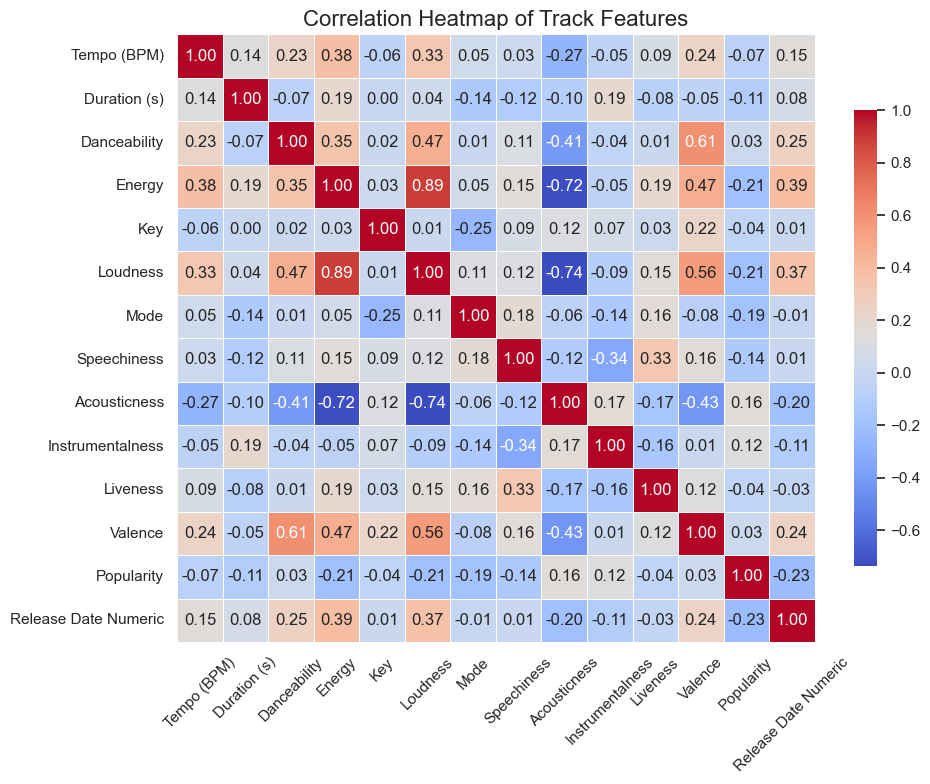

In [102]:
# Replace 'N/A' or 'No data' with NaN
df.replace({'N/A': pd.NA, 'No data': pd.NA}, inplace=True)

# Convert 'Release Date' to datetime format (assuming 'YYYY-MM-DD' format)
df['Release Date'] = pd.to_datetime(df['Release Date'], format='%Y-%m-%d', errors='coerce')

# Convert 'Release Date' to a numerical format (timestamp), handling NaT values
df['Release Date Numeric'] = df['Release Date'].apply(lambda x: x.timestamp() if pd.notnull(x) else pd.NA)

# Define the list of numeric columns
numeric_cols = ['Tempo (BPM)', 'Duration (s)', 'Danceability', 'Energy', 
                'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 
                'Instrumentalness', 'Liveness', 'Valence', 'Popularity', 'Release Date Numeric']

# Ensure these columns are numeric
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Set the style of the visualization
sns.set(style='white')

# Compute the correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, cbar_kws={"shrink": .75})

# Add titles and labels
plt.title('Correlation Heatmap of Track Features', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


In [22]:
# Convert 'N/A' or 'No data' to NaN
df.replace({'N/A': pd.NA, 'No data': pd.NA}, inplace=True)

# Convert 'Release Date' to datetime format
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')

# Convert relevant columns to numeric
numeric_cols = ['Energy', 'Valence', 'Instrumentalness', 'Loudness', 'Acousticness']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Convert 'Release Date' to a numeric format (timestamp), handling NaT values
df['Release Date Numeric'] = df['Release Date'].apply(lambda x: x.timestamp() if pd.notnull(x) else pd.NA)

# Normalize 'Release Date' to be in the range [0, 1]
df['ReleaseDateNorm'] = (df['Release Date Numeric'] - df['Release Date Numeric'].min()) / (df['Release Date Numeric'].max() - df['Release Date Numeric'].min())

# Calculate the weight for Loudness
df['AdjustedLoudnessWeight'] = 1 - df['ReleaseDateNorm']

# Calculate the raw Bangerness score with adjusted Loudness weight
df['Bangerness'] = (9.9 * df['Energy'] +
                    0.1 * df['Valence'] +
                    0.2 * df['Instrumentalness'] +
                    0.1 * df['AdjustedLoudnessWeight'] * df['Loudness']) - df['Acousticness']

# Normalize the Bangerness score to the range [0, 1]
min_bangerness = df['Bangerness'].min()
max_bangerness = df['Bangerness'].max()
df['Bangerness'] = (df['Bangerness'] - min_bangerness) / (max_bangerness - min_bangerness)

# Sort DataFrame based on Bangerness
df_sorted = df.sort_values(['Bangerness'], ascending=False)

# Drop intermediate columns used for calculations
df_sorted = df_sorted.drop(columns=['ReleaseDateNorm', 'AdjustedLoudnessWeight', 'Release Date Numeric'])

# Extract the first word from 'Track Name'
df_sorted['First Word'] = df_sorted['Track Name'].str.split().str[0]

# Drop duplicates based on 'First Word', keeping the first occurrence
df_sorted_unique = df_sorted.drop_duplicates(subset='First Word', keep='first')

# Drop the 'First Word' column as it's no longer needed
df_sorted_unique = df_sorted_unique.drop(columns=['First Word'])

# Display the top 10 rows of the sorted and unique DataFrame
df_sorted_unique[['Album Name', 'Track Name', 'Release Date', 'Tempo (BPM)', 'Instrumentalness', 
                  'Popularity', 'Danceability', 'Energy', 'Valence', 'Loudness', 
                  'Acousticness', 'Bangerness']].head(10)


,Album Name,Track Name,Release Date,Tempo (BPM),Instrumentalness,Popularity,Danceability,Energy,Valence,Loudness,Acousticness,Bangerness
1,Digeridoo (Expanded Edition),Flap Head - 2022 Remaster,2024-05-31,136.244,0.886,35,0.566,0.995,0.592,-7.022,0.15100,1.000000
7,Digeridoo (Expanded Edition),Phloam - Cr7E Version,2024-05-31,132.169,0.477,24,0.536,0.979,0.191,-8.182,0.00102,0.990193
64,Richard D. James Album,Carn Marth,1996-11-04,166.895,0.747,34,0.599,0.997,0.585,-3.264,0.05250,0.985794
5,Digeridoo (Expanded Edition),"Digeridoo - Cr7E Version, Live In Cornwall",2024-05-31,142.803,0.900,26,0.525,0.986,0.370,-8.186,0.55500,0.961432
17,Syro,CIRCLONT14 [152.97][shrymoming mix],2014-09-22,152.969,0.928,34,0.671,0.978,0.178,-7.304,0.27900,0.958732
37,Drukqs,54 Cymru Beats,2001-10-22,168.012,0.694,35,0.632,0.967,0.390,-6.048,0.01640,0.953008
76,...I Care Because You Do,Start As You Mean To Go On,1995-04-24,150.950,0.926,29,0.610,0.992,0.542,-8.606,0.00235,0.950830
48,Drukqs,Afx237 v.7,2001-10-22,168.100,0.632,32,0.635,0.975,0.211,-7.318,0.01870,0.949827
23,Drukqs,Vordhosbn,2001-10-22,170.071,0.865,44,0.662,0.960,0.605,-6.619,0.04790,0.946607
67,Richard D. James Album,Yellow Calx,1996-11-04,166.953,0.828,37,0.291,0.964,0.541,-6.704,0.15800,0.932064


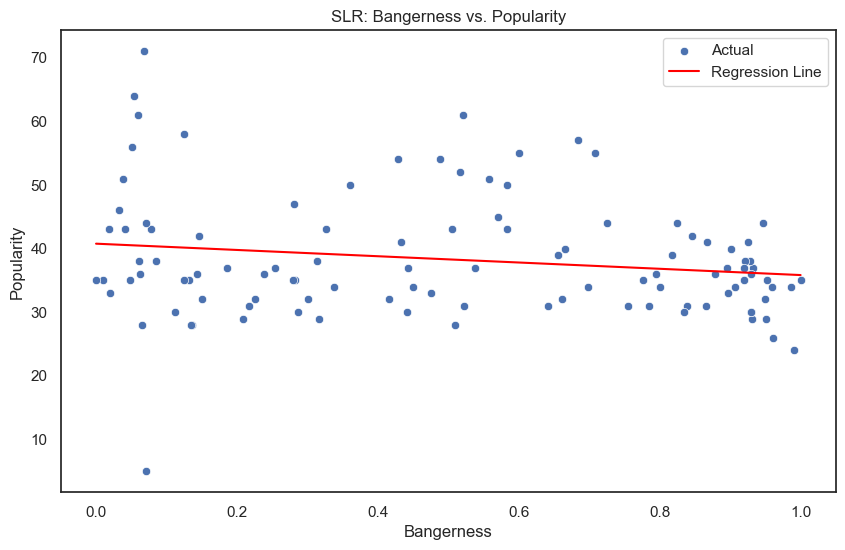

Coefficient (Slope): -4.930778324139821
Intercept: 40.76076926227486
Mean Squared Error (MSE): 88.68235746747783


In [15]:
# Ensure there are no NaN values in the columns
df_sorted_unique = df_sorted_unique.dropna(subset=['Bangerness', 'Popularity'])

# Reshape data for SLR
X = df_sorted_unique[['Bangerness']].values.reshape(-1, 1)  # Bangerness as predictor
y = df_sorted_unique['Popularity'].values  # Popularity as target

# Perform Simple Linear Regression
model = LinearRegression()
model.fit(X, y)

# Predicted values
y_pred = model.predict(X)

# Plot the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Bangerness', y='Popularity', data=df_sorted_unique, label='Actual')
plt.plot(df_sorted_unique['Bangerness'], y_pred, color='red', label='Regression Line')
plt.title('SLR: Bangerness vs. Popularity')
plt.xlabel('Bangerness')
plt.ylabel('Popularity')
plt.legend()
plt.show()

# Output the SLR results
print(f"Coefficient (Slope): {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")
print(f"Mean Squared Error (MSE): {np.mean((y_pred - y) ** 2)}")


In [16]:
df_sorted = df.sort_values(['Popularity'], ascending=False)
df_sorted.head(10)
df_sorted[['Track Name', 'Popularity', 'Tempo (BPM)', 'Duration (s)', 
            'Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 
            'Speechiness', 'Acousticness', 'Instrumentalness', 
            'Liveness', 'Valence', 'Release Date', 'Bangerness']].head(10)

,Track Name,Popularity,Tempo (BPM),Duration (s),Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Release Date,Bangerness
40,QKThr,71,79.042,87.467,0.451,0.0223,1.0,-26.117,1.0,0.0461,0.99300,0.768,0.1300,0.0573,2001-10-22,0.068619
30,Avril 14th,64,157.811,125.520,0.558,0.0259,8.0,-30.016,1.0,0.0458,0.99600,0.871,0.0969,0.3700,2001-10-22,0.054445
106,Xtal,61,114.532,293.752,0.510,0.5050,9.0,-13.053,0.0,0.0344,0.34200,0.960,0.1170,0.3180,1992-02-10,0.521391
84,#3,61,146.977,464.293,0.159,0.0710,6.0,-27.109,0.0,0.0409,0.91100,0.856,0.1070,0.0602,1994-03-07,0.059024
21,aisatsana [102],58,101.390,321.880,0.260,0.0100,4.0,-32.894,0.0,0.0359,0.98000,0.843,0.1310,0.0349,2014-09-22,0.124687
53,Flim,57,147.980,177.093,0.710,0.7340,0.0,-14.932,0.0,0.0520,0.51300,0.836,0.0701,0.4000,1997-10-06,0.683408
110,I,56,76.923,77.347,0.183,0.0896,2.0,-27.540,1.0,0.0486,0.98900,0.899,0.1070,0.0326,1992-02-10,0.051136
79,Alberto Balsalm,55,93.988,310.747,0.791,0.5990,3.0,-13.648,1.0,0.1450,0.31500,0.928,0.1110,0.5700,1995-04-24,0.600568
14,180db_ [130],55,130.064,191.467,0.828,0.6100,1.0,-7.305,1.0,0.0648,0.00104,0.894,0.0792,0.5660,2014-09-22,0.707890
108,Pulsewidth,54,119.319,228.053,0.765,0.4860,1.0,-14.671,1.0,0.0724,0.42000,0.876,0.3320,0.3030,1992-02-10,0.487813


In [17]:
df_pop = df_sorted.head(10)

Mean Squared Error: 12.90411659354638
R² Score: 0.47883212465483116


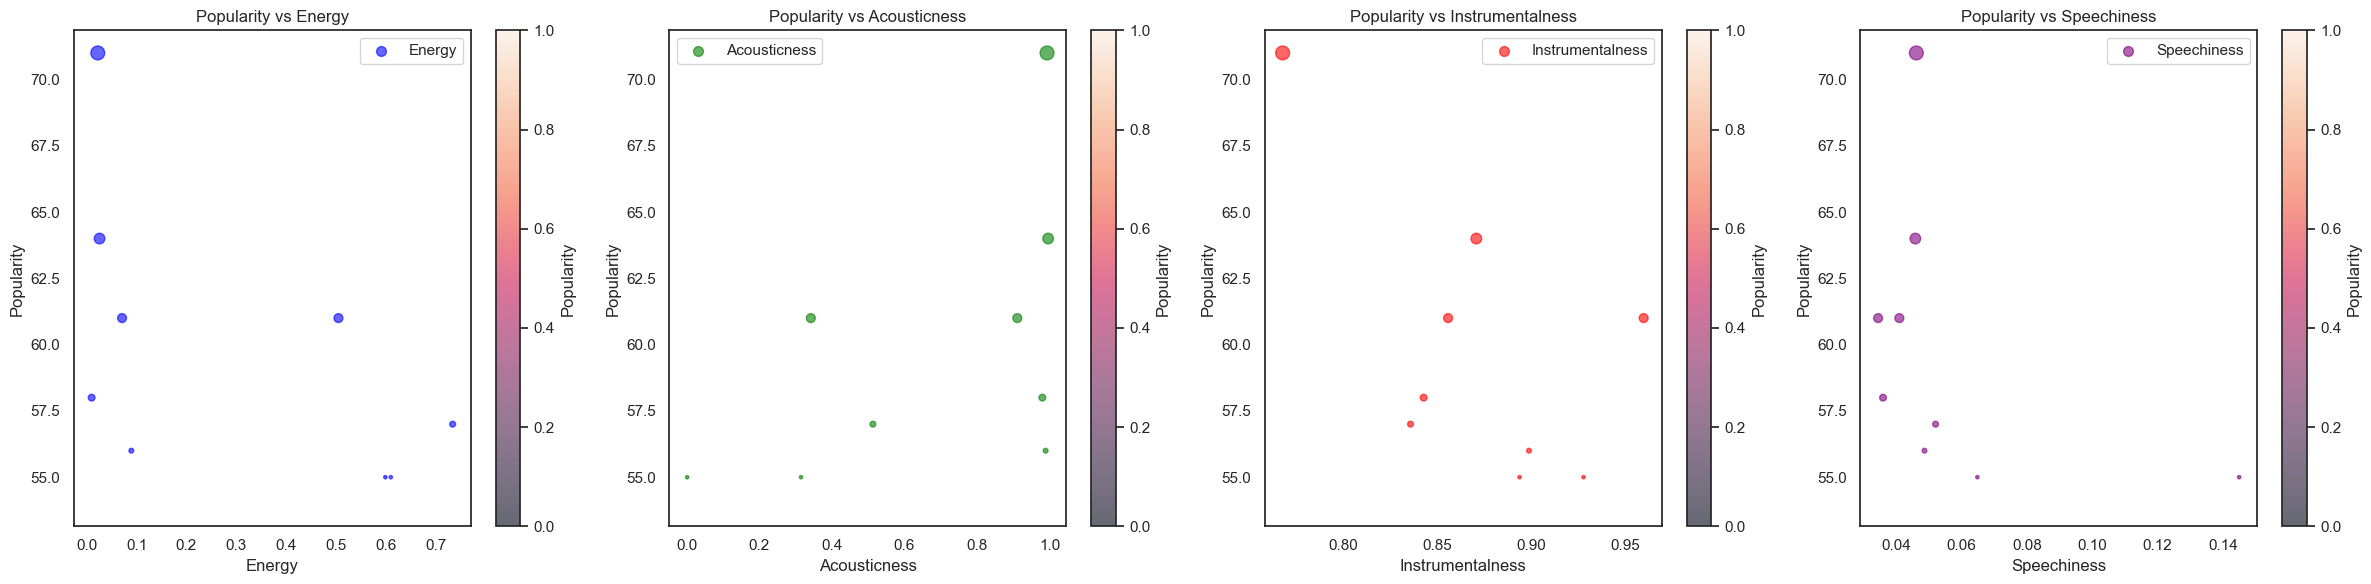

In [18]:
# Prepare the data
X = df_pop[['Energy', 'Acousticness', 'Instrumentalness', 'Speechiness']].values
y = df_pop['Popularity'].values

# Handle missing values and scale features
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Impute missing values
X = imputer.fit_transform(X)

# Scale features
X = scaler.fit_transform(X)

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Scaling for dot sizes
popularity_scaled = (y - y.min()) / (y.max() - y.min()) * 100  # Scale to range 0-100

# Plotting
plt.figure(figsize=(24, 6))

# Scatter plot for Energy vs Popularity
plt.subplot(1, 4, 1)
plt.scatter(df_pop['Energy'], y, c='blue', s=popularity_scaled, alpha=0.6, label='Energy')
plt.xlabel('Energy')
plt.ylabel('Popularity')
plt.title('Popularity vs Energy')
plt.colorbar(label='Popularity')
plt.legend()

# Scatter plot for Acousticness vs Popularity
plt.subplot(1, 4, 2)
plt.scatter(df_pop['Acousticness'], y, c='green', s=popularity_scaled, alpha=0.6, label='Acousticness')
plt.xlabel('Acousticness')
plt.ylabel('Popularity')
plt.title('Popularity vs Acousticness')
plt.colorbar(label='Popularity')
plt.legend()

# Scatter plot for Instrumentalness vs Popularity
plt.subplot(1, 4, 3)
plt.scatter(df_pop['Instrumentalness'], y, c='red', s=popularity_scaled, alpha=0.6, label='Instrumentalness')
plt.xlabel('Instrumentalness')
plt.ylabel('Popularity')
plt.title('Popularity vs Instrumentalness')
plt.colorbar(label='Popularity')
plt.legend()

# Scatter plot for Speechiness vs Popularity
plt.subplot(1, 4, 4)
plt.scatter(df_pop['Speechiness'], y, c='purple', s=popularity_scaled, alpha=0.6, label='Speechiness')
plt.xlabel('Speechiness')
plt.ylabel('Popularity')
plt.title('Popularity vs Speechiness')
plt.colorbar(label='Popularity')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
# Ensure all relevant columns are numeric
df_sorted_unique['Energy'] = pd.to_numeric(df_sorted_unique['Energy'], errors='coerce')
df_sorted_unique['Acousticness'] = pd.to_numeric(df_sorted_unique['Acousticness'], errors='coerce')
df_sorted_unique['Instrumentalness'] = pd.to_numeric(df_sorted_unique['Instrumentalness'], errors='coerce')
df_sorted_unique['Speechiness'] = pd.to_numeric(df_sorted_unique['Speechiness'], errors='coerce')
df_sorted_unique['Liveness'] = pd.to_numeric(df_sorted_unique['Liveness'], errors='coerce')
df_sorted_unique['Danceability'] = pd.to_numeric(df_sorted_unique['Danceability'], errors='coerce')

# Handle potential NaN values by filling them with the median of the respective columns
df_sorted_unique.fillna({
    'Energy': df_sorted_unique['Energy'].median(),
    'Acousticness': df_sorted_unique['Acousticness'].median(),
    'Instrumentalness': df_sorted_unique['Instrumentalness'].median(),
    'Speechiness': df_sorted_unique['Speechiness'].median(),
    'Liveness': df_sorted_unique['Liveness'].median(),
    'Danceability': df_sorted_unique['Danceability'].median()
}, inplace=True)

# Invert the scales where lower values should contribute positively to Ambientness
df_sorted_unique['Energy_inverse'] = 1 - df_sorted_unique['Energy']
df_sorted_unique['Speechiness_inverse'] = 1 - df_sorted_unique['Speechiness']
df_sorted_unique['Liveness_inverse'] = 1 - df_sorted_unique['Liveness']
df_sorted_unique['Danceability_inverse'] = 1 - df_sorted_unique['Danceability']

# Calculate the Ambientness score
df_sorted_unique['Ambientness'] = (
    0.20 * df_sorted_unique['Energy_inverse'] +    # Low energy contributes positively
    0.20 * df_sorted_unique['Acousticness'] +      # High acousticness contributes positively
    0.20 * df_sorted_unique['Instrumentalness'] +  # High instrumentalness contributes positively
    0.20 * df_sorted_unique['Speechiness_inverse'] + # Low speechiness contributes positively
    0.10 * df_sorted_unique['Liveness_inverse'] +   # Low liveness contributes positively
    0.10 * df_sorted_unique['Danceability_inverse']  # Low danceability contributes positively
)

# Normalize the Ambientness score to the range [0, 1]
min_ambientness = df_sorted_unique['Ambientness'].min()
max_ambientness = df_sorted_unique['Ambientness'].max()
df_sorted_unique['Ambientness'] = (df_sorted_unique['Ambientness'] - min_ambientness) / (max_ambientness - min_ambientness)

# Display the DataFrame with the new Ambientness column
df_sorted_unique[['Track Name', 'Energy', 'Acousticness', 'Instrumentalness', 
                  'Speechiness', 'Liveness', 'Danceability', 'Ambientness']].head(20)

# Sort by Ambientness and display the top tracks
df_amb = df_sorted_unique.sort_values(['Ambientness'], ascending=False)
df_amb[['Album Name', 'Track Name', 'Popularity', 'Energy', 'Acousticness', 'Instrumentalness', 
       'Speechiness', 'Liveness', 'Danceability', 'Bangerness', 'Valence', 'Ambientness']].head(10)


,Album Name,Track Name,Popularity,Energy,Acousticness,Instrumentalness,Speechiness,Liveness,Danceability,Bangerness,Valence,Ambientness
88,Selected Ambient Works Volume II,#7,43,0.03330,0.994,0.981,0.0371,0.0928,0.161,0.018881,0.0481,1.000000
101,Selected Ambient Works Volume II,#20,51,0.04190,0.971,0.909,0.0418,0.0520,0.108,0.038201,0.0429,0.979681
95,Selected Ambient Works Volume II,#14,35,0.02960,0.992,0.946,0.0502,0.1900,0.124,0.010493,0.0377,0.974684
87,Selected Ambient Works Volume II,#6,35,0.07740,0.995,0.979,0.0423,0.0823,0.226,0.047812,0.0675,0.974336
91,Selected Ambient Works Volume II,#10,33,0.04720,0.974,0.905,0.0419,0.0988,0.105,0.019844,0.0201,0.970315
42,Drukqs,Bit 4,5,0.02320,0.972,0.930,0.0342,0.1400,0.181,0.070544,0.0000,0.969025
81,...I Care Because You Do,Next Heap With,28,0.08530,0.962,0.918,0.0403,0.0939,0.109,0.134272,0.0364,0.958716
46,Drukqs,Petiatil Cx Htdui,43,0.00682,0.996,0.956,0.0391,0.1540,0.421,0.041536,0.1390,0.947342
86,Selected Ambient Works Volume II,#5,36,0.09910,0.965,0.938,0.0434,0.0445,0.250,0.062326,0.0398,0.945578
110,Selected Ambient Works 85-92,I,56,0.08960,0.989,0.899,0.0486,0.1070,0.183,0.051136,0.0326,0.942782


Mean Squared Error: 0.016283374355186914
R² Score: 0.7896685401382803


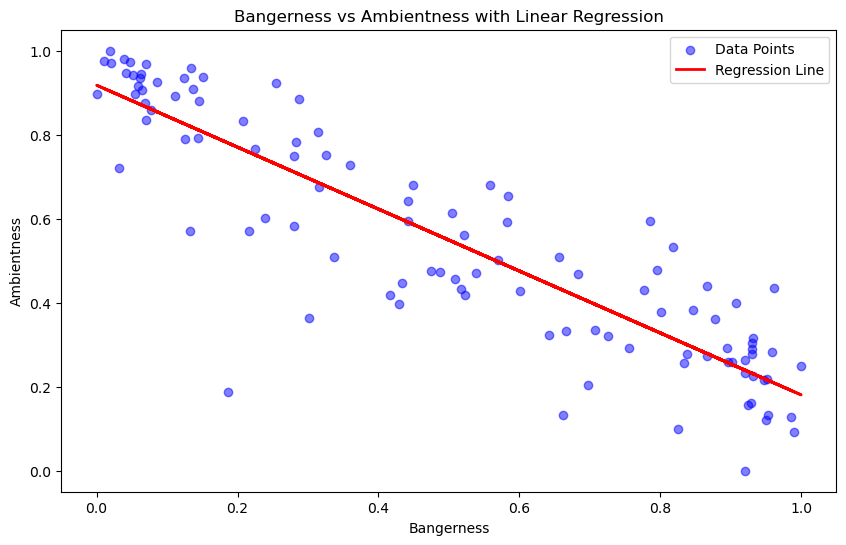

In [19]:
# Prepare the data
X = df_amb['Bangerness'].values.reshape(-1, 1)  # Independent variable
y = df_amb['Ambientness'].values  # Dependent variable

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Plot the data and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.5, label='Data Points')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Bangerness')
plt.ylabel('Ambientness')
plt.title('Bangerness vs Ambientness with Linear Regression')
plt.legend()
plt.show()


looking into entries in the middle = selected ambient works

In [25]:
df_fin = df_amb[['Album Name', 'Track Name', 'Popularity', 'Energy','Danceability', 'Acousticness', 'Instrumentalness', 
                  'Speechiness', 'Liveness','Valence', 'Bangerness', 'Ambientness']]

df_fin_filtered = df_fin[
    ((df_fin['Bangerness'] - df_fin['Ambientness']).abs() < 0.0666) &
    (df_fin['Bangerness'] > 0.4) &
    (df_fin['Ambientness'] > 0.4)
]

df_fin_filtered

,Album Name,Track Name,Popularity,Energy,Danceability,Acousticness,Instrumentalness,Speechiness,Liveness,Valence,Bangerness,Ambientness
112,Selected Ambient Works 85-92,Heliosphan,50,0.612,0.345,0.455000,0.956,0.0416,0.0854,0.1260,0.582746,0.591131
106,Selected Ambient Works 85-92,Xtal,61,0.505,0.510,0.342000,0.960,0.0344,0.1170,0.3180,0.521391,0.560321
71,...I Care Because You Do,The Waxen Pith,33,0.423,0.541,0.077400,0.903,0.0316,0.1180,0.3720,0.474855,0.476661
108,Selected Ambient Works 85-92,Pulsewidth,54,0.486,0.765,0.420000,0.876,0.0724,0.3320,0.3030,0.487813,0.474278
77,...I Care Because You Do,Wet Tip Hen Ax,28,0.416,0.677,0.103000,0.879,0.0323,0.1240,0.0919,0.509124,0.455779
117,Selected Ambient Works 85-92,Delphium,41,0.371,0.654,0.020400,0.923,0.0907,0.1010,0.7100,0.432765,0.446182
33,Drukqs,Orban Eq Trx 4,32,0.275,0.776,0.000006,0.795,0.0584,0.1030,0.2690,0.416224,0.419014


Looking into entries with low amb /bang vals

In [26]:
df_filtered_small = df_fin[(df_fin['Bangerness'] < 0.4) & (df_fin['Ambientness'] < 0.4)]
df_filtered_small

,Album Name,Track Name,Popularity,Energy,Danceability,Acousticness,Instrumentalness,Speechiness,Liveness,Valence,Bangerness,Ambientness
32,Drukqs,Gwarek2,32,0.235,0.288,0.0704,0.512,0.179,0.335,0.0379,0.301320,0.364342
39,Drukqs,Lornaderek,37,0.144,0.758,0.9890,0.000,0.913,0.461,0.7200,0.185789,0.187491
